This notebook takes a list of CARDAMOM cbf and cbr files unique to a lat/lon and performs the following operations: 

 -  1) create a list of cardamom output file paths.
 -   2) execute a forward CARDAMOM run for each cbf,cbr,output filepath triplet 
 -  3) opens the full output in xarray 
 -  4) trims the posterior 
 -  5) extracts the data variables and derived quantities of interest while re-labeling them with the unique lat/lon so that they can be combined in a gridded array with other output 
 -  6) summarizes statistics across all the MCMC samples to reduce filesize and 
 -  7) merges them into gridded datasets.

It also does this for the data constraint files, but without the step of extracting statistics. 


In [1]:
import os
import sys
import string
import subprocess
import xarray as xr

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import MFDataset
from netCDF4 import Dataset
from IPython.display import display, Math, Latex
import pandas as pd
from matplotlib import cm
import datetime
from datetime import datetime, timedelta
from operator import * 
from matplotlib.dates import DateFormatter
import subprocess

#Fit display to window size
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

os.getcwd()

'/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts'

In [2]:
import os

# Check if DYLD_LIBRARY_PATH is in the environment
if 'DYLD_LIBRARY_PATH' in os.environ:
    print(f"DYLD_LIBRARY_PATH is set: {os.environ['DYLD_LIBRARY_PATH']}")
else:
    print("DYLD_LIBRARY_PATH is NOT set in the Python environment.")

DYLD_LIBRARY_PATH is set: /Users/bilir/miniforge3/lib:


In [3]:
# Function to label pools/fluxes/parameters from Paul Levine 10.27.22
def dalec_model_info(mod_id,code_dir):
    mod_id = int(mod_id)
    info = {'ID':mod_id}
    dalec_path = code_dir + '/C/projects/CARDAMOM_MODELS/DALEC/DALEC_{}'.format(mod_id)
    with open(dalec_path + '/DALEC_{}.c'.format(mod_id), 'r') as file:
        dalec_string = file.read()
        info['nopools'] = int(dalec_string.split('DALECmodel->nopools=')[1].split(';')[0])
        info['nomet'] = int(dalec_string.split('DALECmodel->nomet=')[1].split(';')[0])
        info['nopars'] = int(dalec_string.split('DALECmodel->nopars=')[1].split(';')[0])
        info['nofluxes'] = int(dalec_string.split('DALECmodel->nofluxes=')[1].split(';')[0])
        indices_file = dalec_path + '/DALEC_{}_INDICES.c'.format(mod_id)
        if os.path.isfile(indices_file):
            with open(indices_file, 'r') as file:
                indices_string = file.read()
        else:
            indices_string = dalec_string
        parlist = indices_string.split('DALEC_{}_PARAMETERS'.format(mod_id))[1].split('\n')
        parlist = [par.split('int ')[1].split(';')[0] for par in parlist if 'int' in par]
        info['pars'] = parlist
        info['par_inds'] = {parname:index for parname,index in zip(parlist,range(info['nopars']))}
        fluxlist = indices_string.split('DALEC_{}_FLUXES'.format(mod_id))[1].split('\n')
        fluxlist = [flux.split('int ')[1].split(';')[0] for flux in fluxlist if 'int' in flux]
        info['fluxes'] = fluxlist
        info['flux_inds'] = {fluxname:index for fluxname,index in zip(fluxlist,range(info['nofluxes']))}
        poollist = indices_string.split('DALEC_{}_POOLS'.format(mod_id))[1].split('\n')
        poollist = [pool.split('int ')[1].split(';')[0] for pool in poollist if 'int' in pool]
        info['pools'] = poollist
        info['pool_inds'] = {poolname:index for poolname,index in zip(poollist,range(info['nopools']))}
        pars_info_file = code_dir + '/C/projects/CARDAMOM_MODELS/DALEC/DALEC_{0}/PARS_INFO_{0}.c'.format(mod_id)
        with open(pars_info_file, 'r') as file:
            parinfo_string = file.read()
            par_mins,par_maxs = {},{}
        for par in info['par_inds']:
            par_mins[par] = float(parinfo_string.split('parmin[P.{}]='.format(par))[1].split(';')[0])
            par_maxs[par]  = float(parinfo_string.split('parmax[P.{}]='.format(par))[1].split(';')[0])
            info['par_mins'],info['par_maxs'] = par_mins,par_maxs
            likelihood_file = code_dir + 'C/projects/COST_FUNCTION/MODEL_LIKELIHOOD_FUNCTIONS/DALEC_ALL_LIKELIHOOD.c'
            with open(likelihood_file, 'r') as file:
                likelihood_string = file.read()
                info['likelihood_inds'] = {s.split(';')[0]:i for i,s in enumerate(
                likelihood_string.split('struct LIKELIHOOD_INDICES{')[1].split('} LIKELIHOOD_INDICES')[0].split('int ')[1:]
                )}
    return info

In [4]:
mod_id = 1100
code_dir = '/Users/bilir/Desktop/CARDAMOM_2.1.6c/' 
info = dalec_model_info(mod_id,code_dir)


# Load data


In [5]:
os.getcwd()

'/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts'

In [6]:
#Prepare file paths
path_CBF=os.getcwd()+'/../Global/Global4x5/CBF_1100HF_DF15/'



filelist_cbf=[]

for root, dirs, files in os.walk(path_CBF):
    for file in [x for x in files if 'DS' not in x]: 
        filelist_cbf.append(os.path.join(root,file))

        
path_CBR=os.getcwd()+'/../Global/Global4x5/HFDF14/CBR_FILES'

filelist_cbr=[]

filelist_out=[] #for temporary storage; will not exist at the end

for root, dirs, files in os.walk(path_CBR):
    for file in [x for x in files if 'START' not in x and 'DS' not in x and 'meanRO' in x]: 
        filelist_cbr.append(os.path.join(root,file))
        
        file_out=file[:-14]+'-15output.nc'
        root_out=root[:-16]+'Output_HFDF14-15_ext/'
        filelist_out.append(os.path.join(root_out,file_out))
        
        
for filelist in list([filelist_cbf,
                      filelist_cbr,
                      filelist_out]):
    filelist.sort()
    if len(list(x for x in filelist if 'DS' in x))!=0:
        filelist.remove(list(x for x in filelist if 'DS' in x)[0])


In [7]:
filelist_out

['/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_0W_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_105E_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_10E_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_10W_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_125E_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_15E_ID1100HF_DF14-15output.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/Output_HFDF14-15_ext/site10N_15W_ID1100HF_DF14-15output.nc',
 '/Us

In [8]:
test=xr.open_dataset(filelist_cbf[0])

In [9]:
os.path.basename(filelist_cbr[0])[4:-24]

'10N_0W_ID1'

Not every MDF completed so not every .cbf has a .cbr to match; screen those out below

In [11]:
#grab cbf strings
cbfstrings=[]
for file in filelist_cbf:
    cbf_string=os.path.basename(file)[4:-24]
    cbfstrings.append(cbf_string)
    
    #grab cbr strings   
cbrstrings=[]
for file in filelist_cbr:
    cbr_string=os.path.basename(file)[4:-28]  
    cbrstrings.append(cbr_string)
    
    #identify set to drop
cbf_drop=list([x for x in cbfstrings if x not in cbrstrings])
cbf_drop2=list([x for x in filelist_cbf if os.path.basename(x)[4:-24] in cbf_drop])

    #drop identified files from cbf list
filelist_cbf_completed=filelist_cbf.copy()

for i in cbf_drop2:
    filelist_cbf_completed.remove(i)

In [12]:
cbf_drop

['22N_10W', '22N_15W', '22N_5W', '22S_125E', '26N_10W', '26N_15W', '26N_5W']

In [13]:
len(filelist_cbf_completed)

835

In [14]:
filelist_cbr

['/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_0W_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_105E_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_10E_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_10W_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_125E_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_15E_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/HFDF14/CBR_FILES/site10N_15W_ID1100HF_DF14meanRO.cbf.cbr',
 '/Users/bilir/Desk

In [15]:
cbf_drop2

['/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site22N_10W_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site22N_15W_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site22N_5W_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site22S_125E_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site26N_10W_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site26N_15W_HFDF15_2001-2024.cbf.nc',
 '/Users/bilir/Desktop/CardamomScratch/Concatenation_scripts/../Global/Global4x5/CBF_1100HF_DF15/site26N_5W_HFDF15_2001-2024.cbf.nc']

In [16]:
len(cbf_drop2)

7

# Output

Make coordinate scaffolding to insert things into

In [17]:

dates2=xr.open_dataset(
    '/Users/bilir/Desktop/CardamomScratch/Global/Global4x5/CBF_1100HF_DF15/site10N_0W_HFDF15_2001-2024.cbf.nc').time.values



In [18]:
dates2=xr.open_dataset(
    '/Users/bilir/Desktop/CardamomScratch/Global/Global4x5/CBF_1100HF_DF15/site10N_0W_HFDF15_2001-2024.cbf.nc').time.values


dates3=pd.date_range(start='2000-12-01',end='2025-01-01',freq='ME')+timedelta(days=1)

In [54]:
LandFrac=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/CARDAMOM-MAPS_GC4x5_LAND_SEA_FRAC.nc')

import math
from math import *
#get Area of grid cell at given latitude: follow formula from GEOSChem_xygrids
Areas=(111111.111**2)*(4*5)*np.cos(LandFrac.latitude*pi/180)

#Add full grid cell area to arrays:
LandFrac['PixArea']=xr.DataArray(np.repeat(Areas.data,72).reshape(46, 72),
                          coords={'latitude':LandFrac.latitude.data,'longitude':LandFrac.longitude.data,},dims=['latitude','longitude'])


LandFrac['LandArea']=LandFrac['PixArea']*LandFrac['data']



In [20]:
Extent=LandFrac.data[dict(latitude=np.arange(len(LandFrac.latitude))[9:-2])].transpose().where(LandFrac.data>.25).copy()

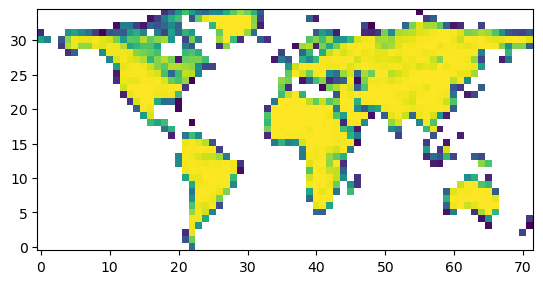

In [21]:
plt.imshow(Extent,origin='lower')

In [22]:
#Scaffolding for storing 6 quantiles of samples
start = xr.Dataset(data_vars=dict(empty=(['time_fluxes','latitude','longitude','quantile'],np.empty((288,len(Extent.latitude.data),len(Extent.longitude.data),6)))),
                                        

                      coords=dict(time_pools=(['time_pools'],dates3),time_fluxes=(['time_fluxes'],dates2),
longitude=(['longitude'],Extent.longitude.data),
                                  latitude=(['latitude'],Extent.latitude.data),
                      quantile=(['quantile'],[0.025,0.25, 0.5, 0.75, 0.975,1])))

In [23]:
for a,b,c in list(zip(
sorted(filelist_cbf_completed),                     
sorted(filelist_cbr),                        
sorted(filelist_out),
)):

    
    sitea=os.path.basename(a)[4:-24]

    siteb=os.path.basename(b)[4:-28]
#     print(sitee,os.path.basename(e))

    sitec=os.path.basename(c)[4:-26]
#     print(sitei,os.path.basename(i))

    
    
    if ((sitea==siteb) and 
    (siteb==sitec)):
        pass
    else: 
        print(sitea+'fail')

#check all files are properly matching sets 


# Extended forward run

In [222]:
#Set up empty arrays
import time
Outputbase=start.copy()

#Stuff for running CARDAMOM_RUN_MODEL.exe
netcdf_lib_path = "/Users/bilir/miniforge3/lib"
env = os.environ.copy()
env['DYLD_LIBRARY_PATH'] = f"{netcdf_lib_path}:{env.get('DYLD_LIBRARY_PATH', '')}"
path_fwdrun = '/Users/bilir/Desktop/CARDAMOM_2.1.6c/C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe'


i=0
crash=[]
    #For integrating flux differences with cumsum
tempCBF=xr.open_dataset(sorted(filelist_cbf)[0],decode_times=False)
Day_intervals=np.append(tempCBF['time'].diff('time').data,31.1875)
Day_intervals_expanded = Day_intervals[:, np.newaxis, np.newaxis]

for path_cbf,path_cbr,path_out, in list(zip(
sorted(filelist_cbf_completed),                  
sorted(filelist_cbr),                   
sorted(filelist_out),
)):    
    loop_start_time=time.time()
         #increment save counter
    i=i+1
        #extract lat/lon 
    tempCBF=xr.open_dataset(path_cbf)
        #convert to lat/lon value
    RealLat=float(tempCBF.LAT.data)
    RealLon=float(tempCBF.LON.data)
    tempCBF.close()
    
    print('\n\n\n Now doing '+os.path.basename(path_cbf)[4:-24]+ ' \n\n\n')
    
### FORWARD RUN ###   
    
        #Do base forward model run
    print(os.path.basename(path_cbf))
    print(os.path.basename(path_cbr))
    print(os.path.basename(path_out))
            #forward run happens here: 
    try:
        subprocess.run([path_fwdrun, path_cbf, path_cbr, path_out], env=env, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Run failed: {os.path.basename(path_cbf)}")
        print(e.stderr.decode())
        break
        
        #open base dataset 
    temp0=xr.open_dataset(path_out) 
    print('\nopened base')
        #throw away burn-in period:
    n=int(2000)
    tempbase0=temp0.isel(Sample=(temp0.Sample.isin(temp0.Sample[n:]))).copy(deep=True)
    scount=len(np.where(tempbase0.EDCs[dict(**{"EDC Index": 7})]==0)[0]) 
    if scount==0:
        !rm $path_out
        print('all samples fail EDCs')
        continue 
    else: 
        tempbase=tempbase0.isel(Sample=np.where(tempbase0.EDCs[dict(**{"EDC Index": 7})]==0)[0]).copy(deep=True)
        # tempbase=tempbase0.isel(Sample=np.where((tempbase0.EDCs[dict(**{"EDC Index": 7})]==0) & #only keep solutions that pass state ranges EDC
                # (tempbase0.EDCs[dict({'EDC Index': 8})]>tempbase0.EDCs[dict({'EDC Index': 8})].quantile([0.5])))[0]).copy(deep=True)  #eliminate bottom 10% of state trajectories probabilities
                #delete large output file from computer:
        !rm $path_out
        
        ##### MAKE BASE XARRAY #####   
    #extract variables needed for composite values
        GPP=tempbase.FLUXES[:,:,info['flux_inds']['gpp']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        GPP_month=GPP*Day_intervals_expanded
        f_total=tempbase.FLUXES[:,:,info['flux_inds']['f_total']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        f_total_month=f_total*Day_intervals_expanded
        resp_auto=tempbase.FLUXES[:,:,info['flux_inds']['resp_auto']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        resp_auto_month=resp_auto*Day_intervals_expanded
        rh_co2=tempbase.FLUXES[:,:,info['flux_inds']['rh_co2']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        rh_co2_month=rh_co2*Day_intervals_expanded
        rh_ch4=tempbase.FLUXES[:,:,info['flux_inds']['rh_ch4']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        rh_ch4_month=rh_ch4*Day_intervals_expanded
        ABGB=tempbase.POOLS[:,:,info['pool_inds']['C_lab']:info['pool_inds']['C_cwd']].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1)
        Resp_eco=tempbase.FLUXES[:,:,np.r_[info['flux_inds']['resp_auto'],info['flux_inds']['rh_co2']]].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        Resp_eco_month=Resp_eco*Day_intervals_expanded
        NEP=GPP-Resp_eco
        NBP=NEP-tempbase.FLUXES[:,:,info['flux_inds']['f_total']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        NBE=-NBP
        NBE_month=NBE*Day_intervals_expanded
        Soilanddead_C=tempbase.POOLS[:,:,info['pool_inds']['C_cwd']:info['pool_inds']['H2O_LY1']].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1)
        EWT=(tempbase.POOLS[:,:,info['pool_inds']['H2O_LY1']:info['pool_inds']['E_LY1']].sum(axis=2)-
                  tempbase.POOLS[:,:,info['pool_inds']['H2O_LY1']:info['pool_inds']['E_LY1']].sum(axis=2).mean('Time_pools')).data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1)
        PAW=(tempbase.POOLS[:,:,info['pool_inds']['H2O_LY1']:info['pool_inds']['H2O_LY3']].sum(axis=2)).data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1)
        runoff=tempbase.FLUXES[:,:,np.r_[info['flux_inds']['q_ly1'],info['flux_inds']['q_ly2'],info['flux_inds']['q_ly3'],info['flux_inds']['q_surf']]].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        dist=tempbase.FLUXES[:,:,info['flux_inds']['dist_lab']:info['flux_inds']['Rd']].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        Climmort=tempbase.FLUXES[:,:,info['flux_inds']['fx_lab2lit']:info['flux_inds']['fx_cwd2som']].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        Backmort=tempbase.FLUXES[:,:,info['flux_inds']['fol2lit']:info['flux_inds']['cwd2som']].sum(axis=2).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        LAI=tempbase.POOLS[:,:,info['pool_inds']['D_LAI']].data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1)
        ETS=tempbase.FLUXES[:,:,info['flux_inds']['ets']].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
        transp=(tempbase.FLUXES[:,:,info['flux_inds']['transp1']:info['flux_inds']['evap']].sum(axis=2)).data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1)
    
            #store output in array of correct shape: starting with custom variables
        tempbase2=xr.Dataset(data_vars=dict(GPP=(['sample','time_fluxes','latitude','longitude'],GPP),
                                            CS_GPP=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(GPP_month,axis=1)), 
                                            meanGPP=(['sample','latitude','longitude'],GPP.mean(axis=1)),
                                            
                                            NBE=(['sample','time_fluxes','latitude','longitude'],NBE),
                                            meanNBE=(['sample','latitude','longitude'],NBE.mean(axis=1)),
                                            CS_NBE=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(NBE_month,axis=1)),
                                        
                                            Resp_eco=(['sample','time_fluxes','latitude','longitude'], Resp_eco),
                                            meanResp_eco=(['sample','latitude','longitude'],Resp_eco.mean(axis=1)),
                                            CS_Resp_eco=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(Resp_eco_month,axis=1)),
                                        CS_fire=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(f_total_month,axis=1)),
                                        
                                        CS_rhco2=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(rh_co2_month,axis=1)),
                                        CS_rhch4=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(rh_ch4_month,axis=1)),
                                        CS_resp_auto=(['sample','time_fluxes','latitude','longitude'], np.nancumsum(resp_auto_month,axis=1)),
                                        ABGB=(['sample','time_pools','latitude','longitude'],ABGB),
                                            meanABGB=(['sample','latitude','longitude'],ABGB.mean(axis=1)),
                                        Soilanddead_C=(['sample','time_pools','latitude','longitude'],Soilanddead_C),
                                            meanDeadC=(['sample','latitude','longitude'],Soilanddead_C.mean(axis=1)),
                                        TotalC=(['sample','time_pools','latitude','longitude'],ABGB+Soilanddead_C),
                                            meanTotalC=(['sample','latitude','longitude'],(ABGB+Soilanddead_C).mean(axis=1)),
                                        EWT_anom=(['sample','time_pools','latitude','longitude'],EWT),
                                           PAW=(['sample','time_pools','latitude','longitude'],PAW),
                                           runoff=(['sample','time_fluxes','latitude','longitude'],runoff),
                                           dist=(['sample','time_fluxes','latitude','longitude'],dist),
                                           CMort=(['sample','time_fluxes','latitude','longitude'],Climmort),
                                           BMort=(['sample','time_fluxes','latitude','longitude'],Backmort),
                                           LAI=(['sample','time_pools','latitude','longitude'],LAI),
                                           ETS=(['sample','time_fluxes','latitude','longitude'],ETS),
                                            meanETS=(['sample','latitude','longitude'],ETS.mean(axis=1)),
                                            
                                            transp=(['sample','time_fluxes','latitude','longitude'],transp),
                                            meanTransp=(['sample','latitude','longitude'],transp.mean(axis=1)),
                                            
                                           NEP=(['sample','time_fluxes','latitude','longitude'],NEP),
                                           Fire=(['sample','time_fluxes','latitude','longitude'],f_total),),
                      coords=dict(time_pools=(['time_pools'],dates3),time_fluxes=(['time_fluxes'],dates2),
                                    longitude=(['longitude'],np.array([RealLon])),latitude=(['latitude'],np.array([RealLat])),
                                                      sample=(['sample'],tempbase.Sample.data)))    
    
            #Add in all pools
        for PoolInd in list(info['pool_inds']):  
            tempbase2[PoolInd]=xr.DataArray(tempbase.POOLS[:,:,info['pool_inds'][PoolInd]].data.reshape(len(tempbase.Sample),len(tempbase.Time_pools),1,1), 
                                                    dims=['sample','time_pools','latitude','longitude'])
            #Add in all fluxes
        for FluxInd in list(info['flux_inds']):  
            tempbase2[FluxInd]=xr.DataArray(tempbase.FLUXES[:,:,info['flux_inds'][FluxInd]].data.reshape(len(tempbase.Sample),len(tempbase.Time_fluxes),1,1), 
                                                    dims=['sample','time_fluxes','latitude','longitude'])
            #Add in all parameters
        for ParInd in list(info['par_inds']):  
            tempbase2[ParInd]=xr.DataArray(tempbase.PARS[:,info['par_inds'][ParInd]].data.reshape(len(tempbase.Sample),1,1), 
                                                    dims=['sample','latitude','longitude'])
            
        
        #extract mean residence times
            #labileC
        tempbase2['C_labMRT']=tempbase2['C_lab'].mean('time_pools')/(tempbase2['resp_auto_maint']+
        tempbase2['Rd']+
        tempbase2['foliar_prod']+
        tempbase2['root_prod']+
        tempbase2['wood_prod']+
        tempbase2['resp_auto_growth']+
        tempbase2['f_lab']+  
        tempbase2['lab2lit']+
        tempbase2['fx_lab2lit']+
        tempbase2['dist_lab']).mean('time_fluxes')
            #foliarC
        tempbase2['C_folMRT']=tempbase2['C_fol'].mean('time_pools')/(tempbase2['fol2lit']+
        tempbase2['ph_fol2lit']+
        tempbase2['f_fol']+
        tempbase2['fx_fol2lit']+
        tempbase2['dist_fol']).mean('time_fluxes')
            #finerootC
        tempbase2['C_rooMRT']=tempbase2['C_roo'].mean('time_pools')/(tempbase2['roo2lit']+
        tempbase2['f_roo']+
        tempbase2['fx_roo2lit']+
        tempbase2['dist_roo']).mean('time_fluxes')
            #woodC
        tempbase2['C_wooMRT']=tempbase2['C_woo'].mean('time_pools')/(tempbase2['woo2cwd']+
        tempbase2['f_woo']+
        tempbase2['fx_woo2cwd']+
        tempbase2['dist_woo']).mean('time_fluxes')
            #litC
        tempbase2['C_litMRT']=tempbase2['C_lit'].mean('time_pools')/(tempbase2['ae_rh_lit']+
        tempbase2['an_rh_lit']+
        tempbase2['f_lit']+
        tempbase2['lit2som']+
        tempbase2['fx_lit2som']).mean('time_fluxes')
            #cwdC
        tempbase2['C_cwdMRT']=tempbase2['C_cwd'].mean('time_pools')/(tempbase2['ae_rh_cwd']+
        tempbase2['an_rh_cwd']+
        tempbase2['f_cwd']+
        tempbase2['cwd2som']+
        tempbase2['fx_cwd2som']).mean('time_fluxes')
            #somC
        tempbase2['C_somMRT']=tempbase2['C_som'].mean('time_pools')/(tempbase2['ae_rh_som']+
        tempbase2['an_rh_som']+
        tempbase2['f_som']).mean('time_fluxes')
            #liveC-- intentional omission of interpool transfers from labile to structural tissues
        tempbase2['LiveCMRT']=tempbase2['ABGB'].mean('time_pools')/(tempbase2['resp_auto']+
        tempbase2['f_lab']+tempbase2['f_fol']+tempbase2['f_roo']+tempbase2['f_woo']+
        tempbase2['dist']+                                   
        tempbase2['lab2lit']+
        tempbase2['fx_lab2lit']+
        tempbase2['fol2lit']+
        tempbase2['ph_fol2lit']+
        tempbase2['fx_fol2lit']+
        tempbase2['roo2lit']+
        tempbase2['fx_roo2lit']+
        tempbase2['woo2cwd']+
        tempbase2['fx_woo2cwd']).mean('time_fluxes')
            #DeadC-- intentional omission of interpool transfers from lit/cwd to som
        tempbase2['DeadCMRT']=tempbase2['Soilanddead_C'].mean('time_pools')/(tempbase2['rh_co2']+
        tempbase2['rh_ch4']+
        tempbase2['f_lit']+
        tempbase2['f_cwd']+
        tempbase2['f_som']).mean('time_fluxes')
            #TotalC-- intentional omission of interpool transfers from lit/cwd to som
        tempbase2['TotalCMRT']=tempbase2['TotalC'].mean('time_pools')/(tempbase2['rh_co2']+tempbase2['rh_ch4']+tempbase2['resp_auto']+
        tempbase2['f_total']+
        tempbase2['dist']
        ).mean('time_fluxes')
        
            #Add in probability and likelihood information (for base case only)
        tempbase2['ABGB_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 0})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['CH4_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 1})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EWT_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 4})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['GPP_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 5})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['LAI_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 7})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['NBE_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 8})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['ROFF_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 9})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['SCF_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 10})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['FIR_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 11})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['Mean_ABGB']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 13})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['Mean_GPP']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 15})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
    
        tempbase2['PEQ_CUE_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 18})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['PEQ_iniSOM_LH']=xr.DataArray(tempbase.LIKELIHOODS[dict(**{"Likelihood Index": 21})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        
        tempbase2['EDCvcmaxlcma_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 0})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCst_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 8})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCnscr_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 9})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCcfcrr_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 10})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCfffrr_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 11})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCmly1t_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 12})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCmly2t_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 13})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['EDCmly3t_LH']=xr.DataArray(tempbase.EDCs[dict(**{"EDC Index": 14})].median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        
        tempbase2['totalDC_LH']=xr.DataArray(tempbase.LIKELIHOODS.sum("Likelihood Index").median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['totalEDC_LH']=xr.DataArray((tempbase.PROB-tempbase.LIKELIHOODS.sum("Likelihood Index")).median('Sample').data.reshape(1,1), dims=['latitude','longitude'])
        
        tempbase2['PROB_med']=xr.DataArray(tempbase.PROB.median().data.reshape(1,1), dims=['latitude','longitude'])
        tempbase2['PROB_med'].attrs['description']='Median probability of the posterior'
    
        tempbase2['scount']=xr.DataArray(np.array([scount]).reshape(1,1), 
                                                    dims=['latitude','longitude'])
        print('\n'+str(tempbase2['scount'].data)+' of 7000 samples still pass state ranges') 
        
            #release working memory of temp
        temp0.close()
        tempbase0.close()
        tempbase.close()
        print('\nmade base xarray')   
        
        tempbase3=tempbase2.quantile([0.025,0.25, 0.5, 0.75, 0.975,1],dim='sample')
        tempbase2.close()
    
        print('\ngot quantiles')     
        
        #combine smaller tempbase3, etc output array at this lat/lon into array with all other outputs
        Outputbase=xr.merge([Outputbase,tempbase3])
        tempbase3.close()
        
        print('\nmerged all') 
        
        print('\n\n\n'+os.path.basename(path_cbf)[4:-20]+ 'done \n\n\n')
        if (i%5)==0: #for every 5 files, save progress
            Outputbase.to_netcdf(os.path.dirname(filelist_out[0])+'/Outputbase_HFDF14-15.nc')
            
            print(str(i)+' more files concatenated and saved')
        loop_end_time = time.time()
        loop_duration = loop_end_time - loop_start_time
        print(f"Iteration took {loop_duration:.2f} seconds")
    
        




 Now doing 10N_0W 



site10N_0W_HFDF15_2001-2024.cbf.nc
site10N_0W_ID1100HF_DF14meanRO.cbf.cbr
site10N_0W_ID1100HF_DF14-15output.nc

opened base

[[5944]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



10N_0W_HFDdone 



Iteration took 53.73 seconds



 Now doing 10N_105E 



site10N_105E_HFDF15_2001-2024.cbf.nc
site10N_105E_ID1100HF_DF14meanRO.cbf.cbr
site10N_105E_ID1100HF_DF14-15output.nc

opened base

[[5998]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



10N_105E_HFDdone 



Iteration took 56.34 seconds



 Now doing 10N_10E 



site10N_10E_HFDF15_2001-2024.cbf.nc
site10N_10E_ID1100HF_DF14meanRO.cbf.cbr
site10N_10E_ID1100HF_DF14-15output.nc

opened base

[[5633]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



10N_10E_HFDdone 



Iteration took 50.77 seconds



 Now doing 10N_10W 



site10N_10W_HFDF15_2001-2024.cbf.nc
site10N_10W_ID1100HF_DF14meanRO.cbf.cb

/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



got quantiles

merged all



70N_20E_HFDdone 



785 more files concatenated and saved
Iteration took 35.61 seconds



 Now doing 70N_25E 



site70N_25E_HFDF15_2001-2024.cbf.nc
site70N_25E_ID1100HF_DF14meanRO.cbf.cbr
site70N_25E_ID1100HF_DF14-15output.nc

opened base

[[3741]] of 7000 samples still pass state ranges

made base xarray


/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



got quantiles

merged all



70N_25E_HFDdone 



Iteration took 38.64 seconds



 Now doing 70N_30E 



site70N_30E_HFDF15_2001-2024.cbf.nc
site70N_30E_ID1100HF_DF14meanRO.cbf.cbr
site70N_30E_ID1100HF_DF14-15output.nc

opened base

[[4665]] of 7000 samples still pass state ranges

made base xarray


/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



got quantiles

merged all



70N_30E_HFDdone 



Iteration took 44.75 seconds



 Now doing 70N_35E 



site70N_35E_HFDF15_2001-2024.cbf.nc
site70N_35E_ID1100HF_DF14meanRO.cbf.cbr
site70N_35E_ID1100HF_DF14-15output.nc

opened base


/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)



[[5110]] of 7000 samples still pass state ranges

made base xarray


/Users/bilir/miniforge3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



got quantiles

merged all



70N_35E_HFDdone 



Iteration took 46.38 seconds



 Now doing 70N_55E 



site70N_55E_HFDF15_2001-2024.cbf.nc
site70N_55E_ID1100HF_DF14meanRO.cbf.cbr
site70N_55E_ID1100HF_DF14-15output.nc

opened base

[[5421]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



70N_55E_HFDdone 



Iteration took 48.76 seconds



 Now doing 70N_60E 



site70N_60E_HFDF15_2001-2024.cbf.nc
site70N_60E_ID1100HF_DF14meanRO.cbf.cbr
site70N_60E_ID1100HF_DF14-15output.nc

opened base

[[5358]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



70N_60E_HFDdone 



790 more files concatenated and saved
Iteration took 49.89 seconds



 Now doing 70N_65E 



site70N_65E_HFDF15_2001-2024.cbf.nc
site70N_65E_ID1100HF_DF14meanRO.cbf.cbr
site70N_65E_ID1100HF_DF14-15output.nc

opened base

[[4481]] of 7000 samples still pass state ranges

made base xarray

got quantiles

merged all



70N_65E_HFDdone 



Iteration to


merged all



78N_95W_done 





In [207]:
 tempbase=tempbase0.isel(Sample=np.where((tempbase0.EDCs[dict(**{"EDC Index": 7})]==0) & #only keep solutions that pass state ranges EDC
                (tempbase0.EDCs[dict({'EDC Index': 8})]>tempbase0.EDCs[dict({'EDC Index': 8})].quantile([0.1])))[0]).copy(deep=True)  #eliminate bottom 10% of state trajectories probabilities

Text(0.5, 1.0, 'scount')

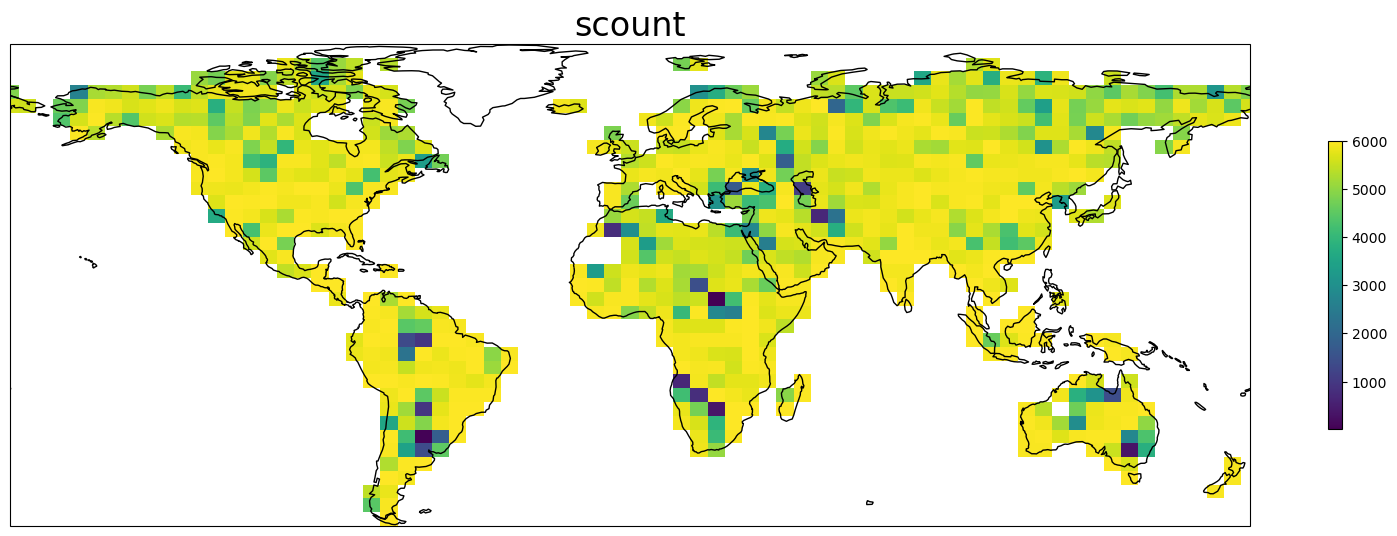

In [228]:
import matplotlib.patches as patches

import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data=Outputbase.scount

C = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15)
plt.title('scount',fontsize=24)

# target_lat = -10
# target_lon = -55
# lon_res = np.abs(data1.longitude.diff('longitude').values[0])
# lat_res = np.abs(data1.latitude.diff('latitude').values[0])
# rect_x = target_lon - lon_res / 2
# rect_y = target_lat - lat_res / 2
# rect = patches.Rectangle((rect_x, rect_y), lon_res, lat_res, linewidth=1, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect)
# # ax.plot(target_lon, target_lat, 'X', color='magenta', markersize=12, transform=ccrs.PlateCarree(), zorder=11)
# plt.show()

Text(0.5, 1.0, '2001-2021 GPP > 2022-2024 GPP')

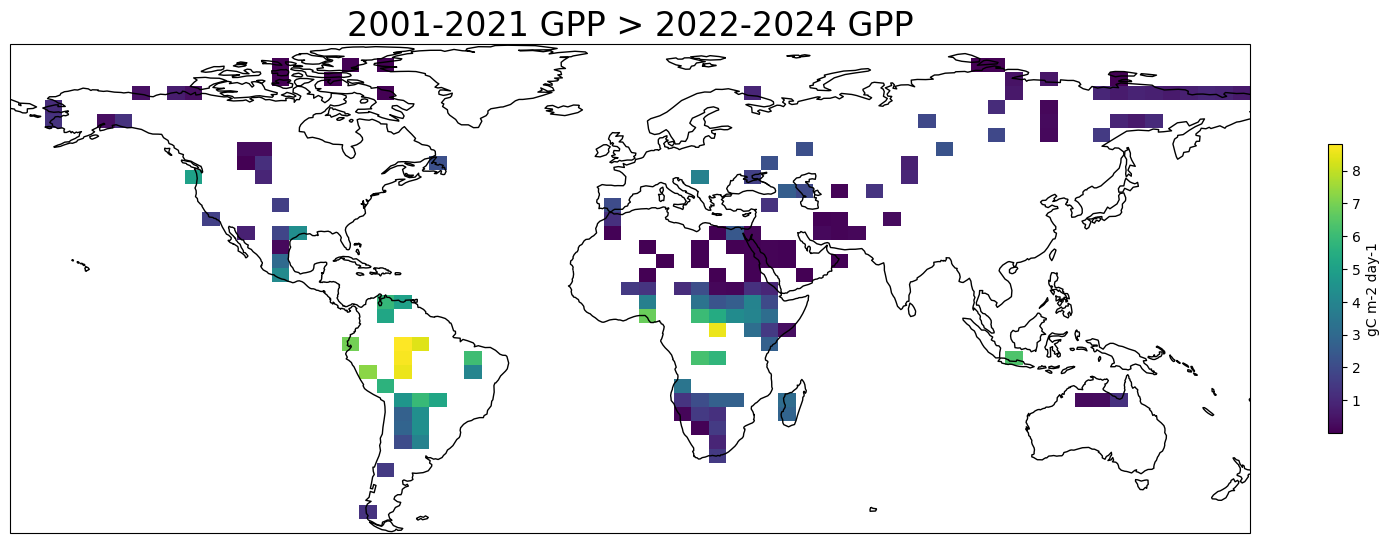

In [242]:
import matplotlib.patches as patches

import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(20,25), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

data1=Outputbase.GPP[dict(quantile=2)].where(
    Outputbase.GPP[dict(quantile=2,time_fluxes=np.arange(252))].mean('time_fluxes') > 
    Outputbase.GPP[dict(quantile=2,time_fluxes=np.arange(252,288))].mean('time_fluxes'))

data2=Outputbase.GPP[dict(quantile=2)].where(
    Outputbase.GPP[dict(quantile=2,time_fluxes=np.arange(252))].mean('time_fluxes') < 
    Outputbase.GPP[dict(quantile=2,time_fluxes=np.arange(252,288))].mean('time_fluxes'))

C = ax.pcolormesh(data1.longitude, data1.latitude, data1.mean('time_fluxes'), transform=ccrs.PlateCarree())
# C.set_clim(vmin=0,vmax=10)
plt.colorbar(C,shrink=.15,label='gC m-2 day-1')
plt.title('2001-2021 GPP > 2022-2024 GPP',fontsize=24)

# target_lat = -10
# target_lon = -55
# lon_res = np.abs(data1.longitude.diff('longitude').values[0])
# lat_res = np.abs(data1.latitude.diff('latitude').values[0])
# rect_x = target_lon - lon_res / 2
# rect_y = target_lat - lat_res / 2
# rect = patches.Rectangle((rect_x, rect_y), lon_res, lat_res, linewidth=1, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect)
# # ax.plot(target_lon, target_lat, 'X', color='magenta', markersize=12, transform=ccrs.PlateCarree(), zorder=11)
# plt.show()

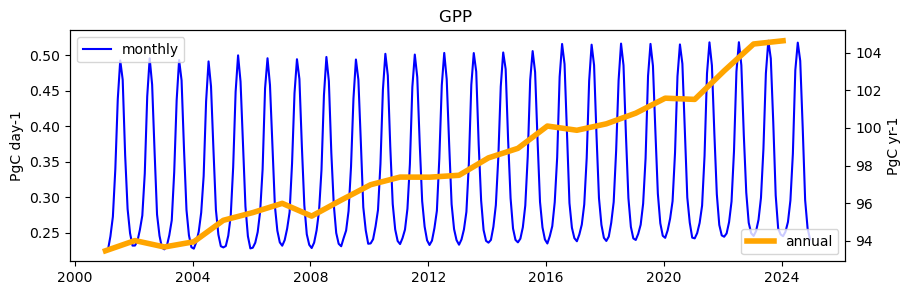

In [227]:
fig,ax=plt.subplots(figsize=(10,3))
data=(Outputbase.GPP*LandFrac.LandArea)[dict(quantile=2)]/1e15
data1=data.where(data[dict(time_fluxes=np.arange(252))].mean('time_fluxes')<data[dict(time_fluxes=np.arange(252,288))].mean('time_fluxes'))
ax.plot(data.time_fluxes,data.sum('latitude').sum('longitude'),color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data1.groupby(data1.time_fluxes.dt.year).mean()*365.25
ax2.plot(data1.time_fluxes[::12],datayear.sum('latitude').sum('longitude'),color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('GPP ')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

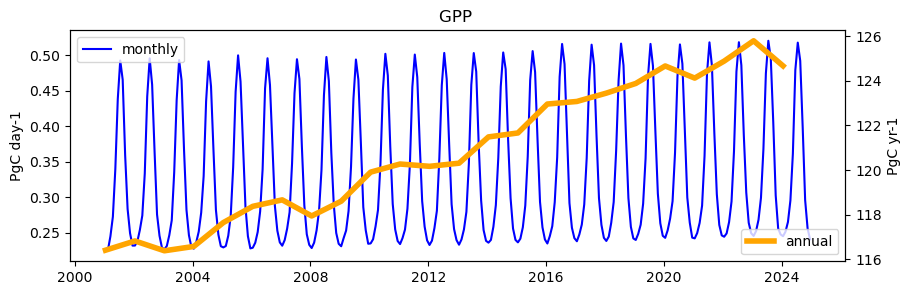

In [223]:
fig,ax=plt.subplots(figsize=(10,3))
data=(Outputbase.GPP*LandFrac.LandArea).sum('latitude').sum('longitude')[dict(quantile=2)]/1e15
ax.plot(data.time_fluxes,data,color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data.groupby(data.time_fluxes.dt.year).mean()*365.25
ax2.plot(data.time_fluxes[::12],datayear,color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('GPP ')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

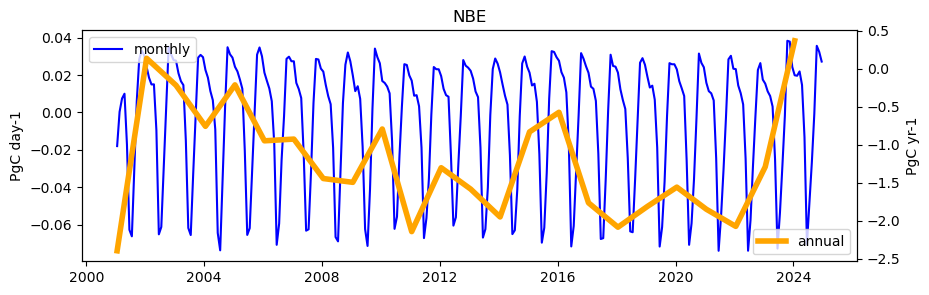

In [237]:
fig,ax=plt.subplots(figsize=(10,3))
data=(Outputbase.NBE*LandFrac.LandArea).sum('latitude').sum('longitude')[dict(quantile=2)]/1e15
ax.plot(data.time_fluxes,data,color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data.groupby(data.time_fluxes.dt.year).mean()*365.25
ax2.plot(data.time_fluxes[::12],datayear,color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('NBE')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

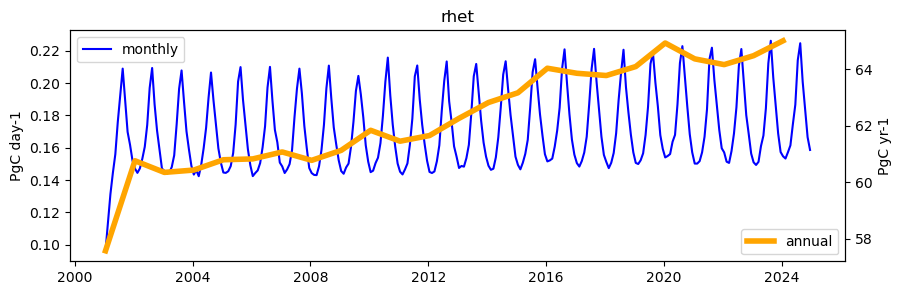

In [238]:
fig,ax=plt.subplots(figsize=(10,3))
data=((Outputbase.rh_co2+Outputbase.rh_ch4)*LandFrac.LandArea).sum('latitude').sum('longitude')[dict(quantile=2)]/1e15
ax.plot(data.time_fluxes,data,color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data.groupby(data.time_fluxes.dt.year).mean()*365.25
ax2.plot(data.time_fluxes[::12],datayear,color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('rhet')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

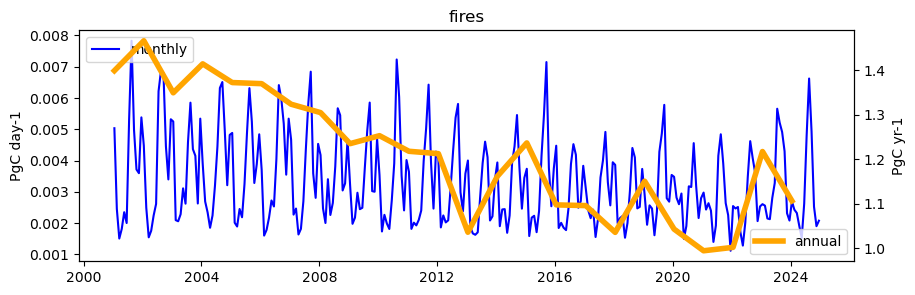

In [239]:
fig,ax=plt.subplots(figsize=(10,3))
data=((Outputbase.f_total)*LandFrac.LandArea).sum('latitude').sum('longitude')[dict(quantile=2)]/1e15
ax.plot(data.time_fluxes,data,color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data.groupby(data.time_fluxes.dt.year).mean()*365.25
ax2.plot(data.time_fluxes[::12],datayear,color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('fires')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

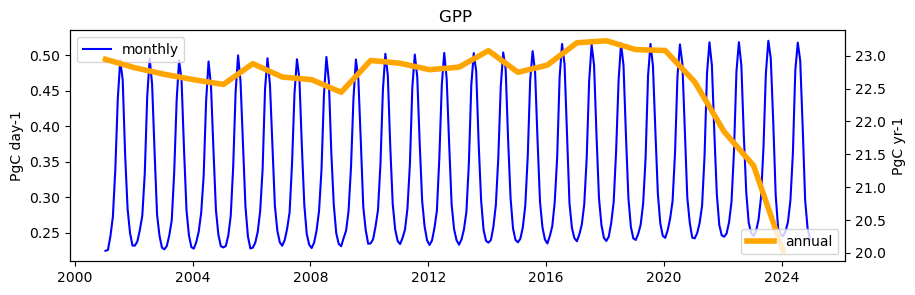

In [225]:
fig,ax=plt.subplots(figsize=(10,3))
data=(Outputbase.GPP*LandFrac.LandArea)[dict(quantile=2)]/1e15
data1=data.where(data[dict(time_fluxes=np.arange(252))].mean('time_fluxes')>data[dict(time_fluxes=np.arange(252,288))].mean('time_fluxes'))
ax.plot(data.time_fluxes,data.sum('latitude').sum('longitude'),color='blue',label='monthly')
ax.set_ylabel('PgC day-1')
ax2=ax.twinx()
datayear=data1.groupby(data1.time_fluxes.dt.year).mean()*365.25
ax2.plot(data1.time_fluxes[::12],datayear.sum('latitude').sum('longitude'),color='orange',linewidth=4,label='annual')
ax2.set_ylabel('PgC yr-1')
plt.title('GPP ')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

Text(0.5, 1.0, 'GPP 10S 55W')

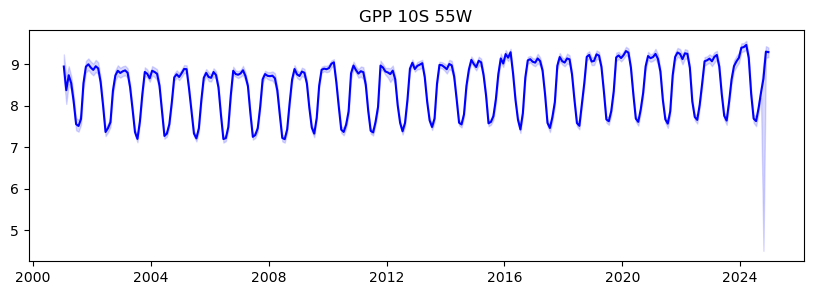

In [236]:
fig,ax=plt.subplots(figsize=(10,3))
data=(Outputbase.GPP)[dict(latitude=np.where(Outputbase.latitude==-10)[0][0],
                           longitude=np.where(Outputbase.longitude==-55)[0][0])]
ax.plot(data.time_fluxes,data[dict(quantile=2)],color='blue',label='monthly')
plt.fill_between(data.time_fluxes,data[dict(quantile=1)],
                 data[dict(quantile=3)], alpha=.15,
                 color='blue',label='monthly')
# ax.set_ylabel('PgC day-1')
# ax2=ax.twinx()
# datayear=data1.groupby(data1.time_fluxes.dt.year).mean()*365.25
# ax2.plot(data1.time_fluxes[::12],datayear.sum('latitude').sum('longitude'),color='orange',linewidth=4,label='annual')
# ax2.set_ylabel('PgC yr-1')
plt.title('GPP 10S 55W')
# ax.legend(loc='upper left')
# ax2.legend(loc='lower right')

# Data Constraint

Make a simpler scaffolding

In [100]:
start2 = xr.Dataset(data_vars=dict(empty=(['time','latitude','longitude'],np.empty((288,len(Extent.latitude.data),len(Extent.longitude.data))))),
                      coords=dict(time=(['time'],dates2),
longitude=(['longitude'],Extent.longitude.data),
                                  latitude=(['latitude'],Extent.latitude.data)))

In [105]:
DCInput=start2.copy()
j=0
for l in filelist_cbf:
    #increment save counter
    j=j+1
        #open dataset
    shape=xr.open_dataset(l)
        #extract lat/lon index
    RealLat=shape.LAT
    RealLon=shape.LON
    start3=start2.copy()
        #resize variables so can assign a lat/lon dimension
    for i in list(shape.keys()):
        if shape[i].size==1: 
            temp=xr.DataArray(shape[i].data.reshape(1,1),
                      coords={'longitude':np.array(RealLon).reshape(1),'latitude':np.array(RealLat).reshape(1)},dims=['latitude','longitude',])
            start3[i]=temp
        if shape[i].size==288: 
            temp=xr.DataArray(shape[i].data.reshape(288,1,1),
                      coords={'time':shape.time.data,'longitude':np.array(RealLon).reshape(1),'latitude':np.array(RealLat).reshape(1)},dims=['time','latitude','longitude',])
            start3[i]=temp
    #Combine
    DCInput=xr.merge([DCInput,start3])
    print(str(l)[70:74]+' done')
    if (j%10)==0: #for ever 10 files, save progress
        DCInput.to_netcdf(os.path.dirname(filelist_out[0])+'/DCInput_HF_DF_4x5.nc')
        print(str(j)+' more files concatenated and saved')

loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
10 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
20 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
30 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
40 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
50 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
60 more files concatenated and saved
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
loba done
70 more files concatenated and saved
loba done
loba done
loba done
loba done
l

In [231]:
DCInput.to_netcdf(os.path.dirname(filelist_out[0])+'/DCInput_ext_4x5.nc')

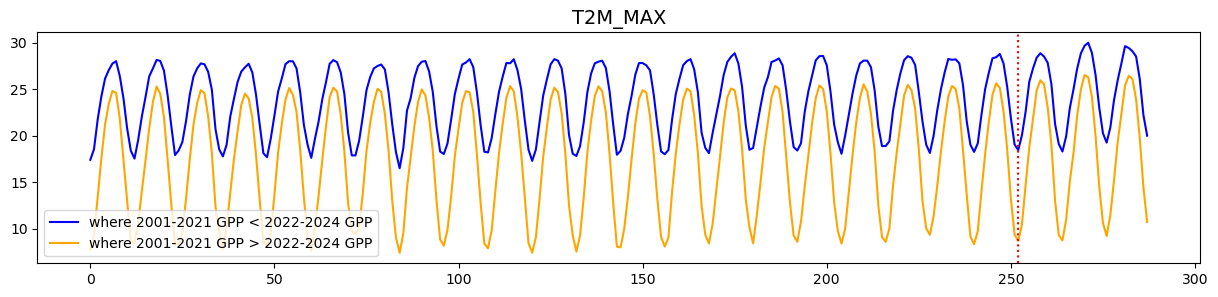

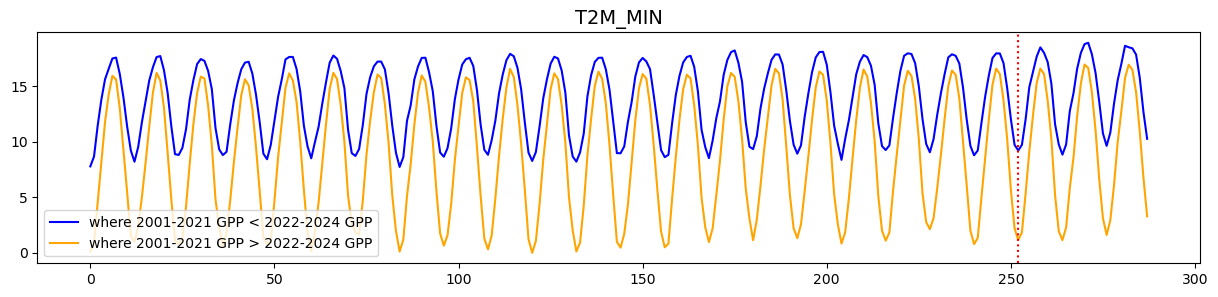

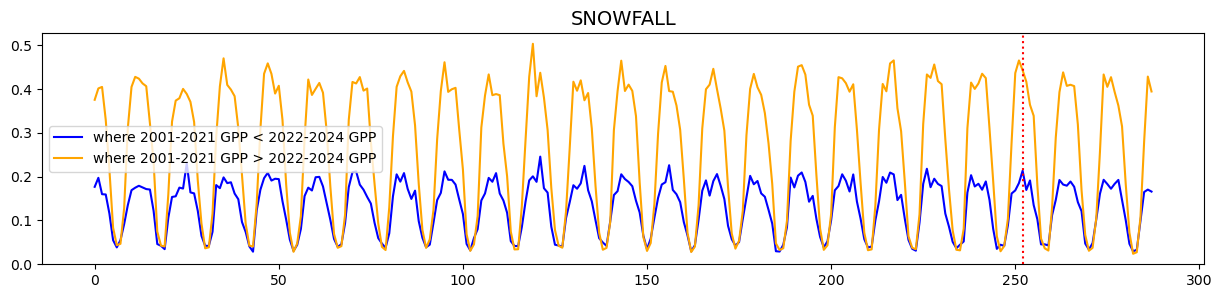

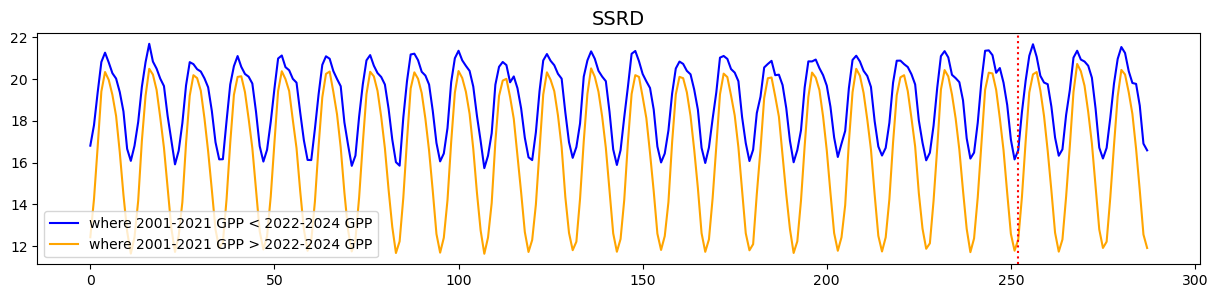

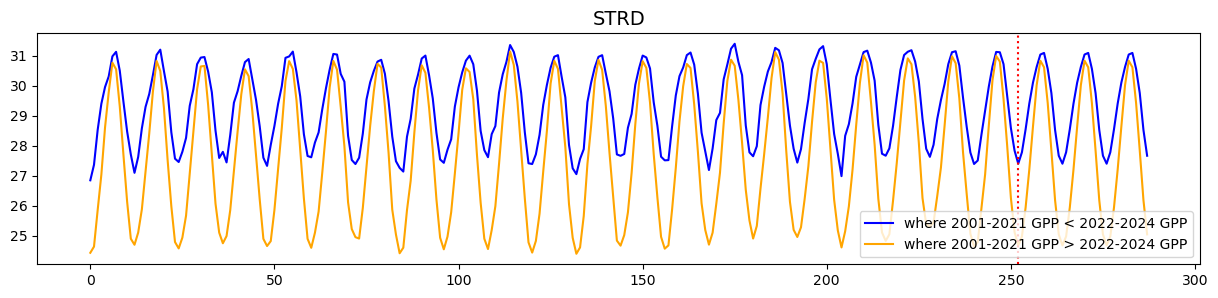

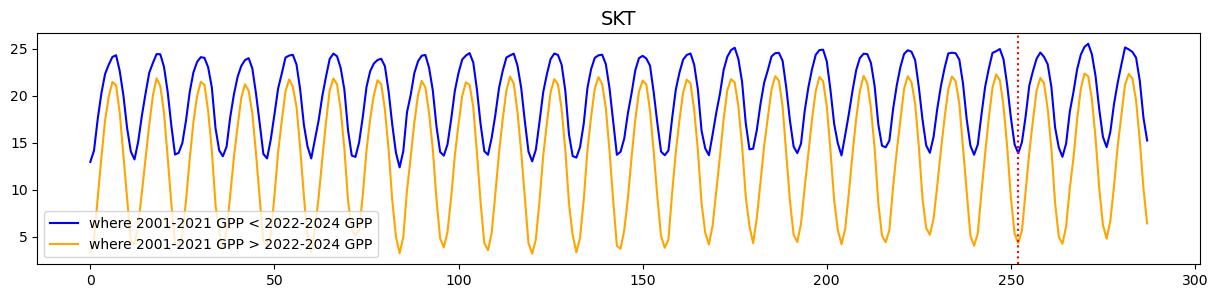

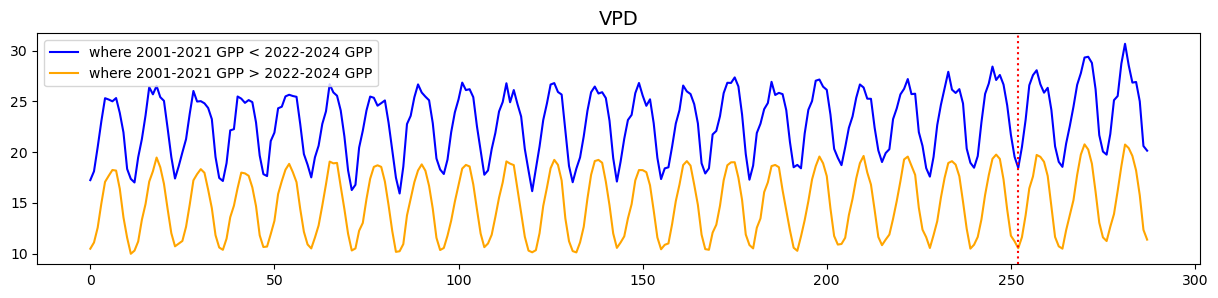

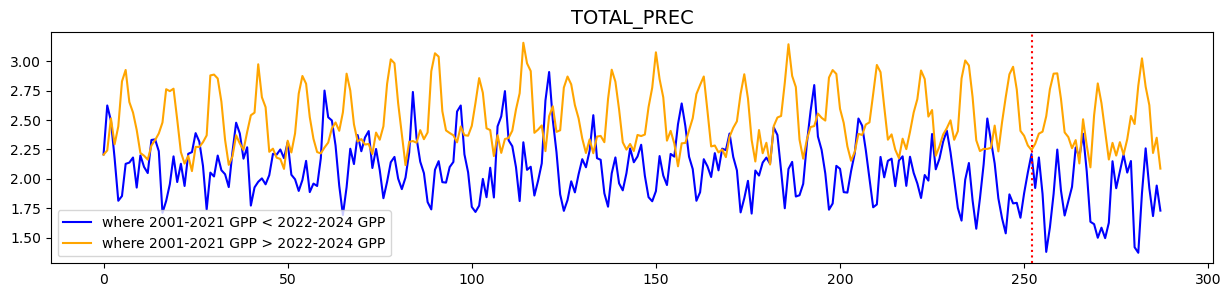

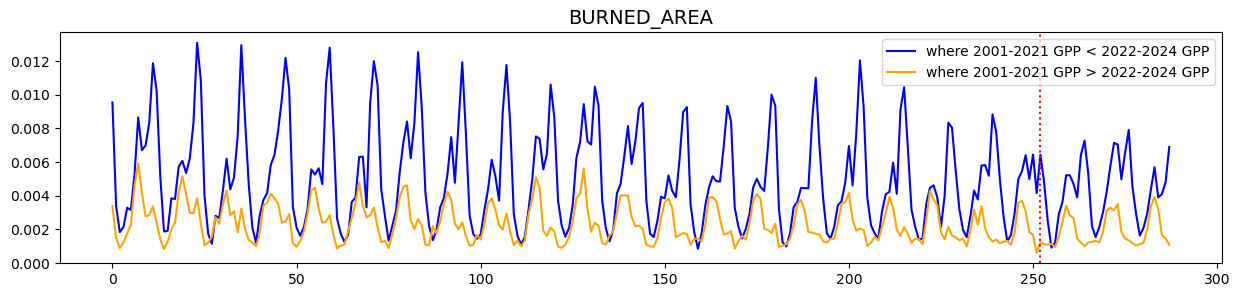

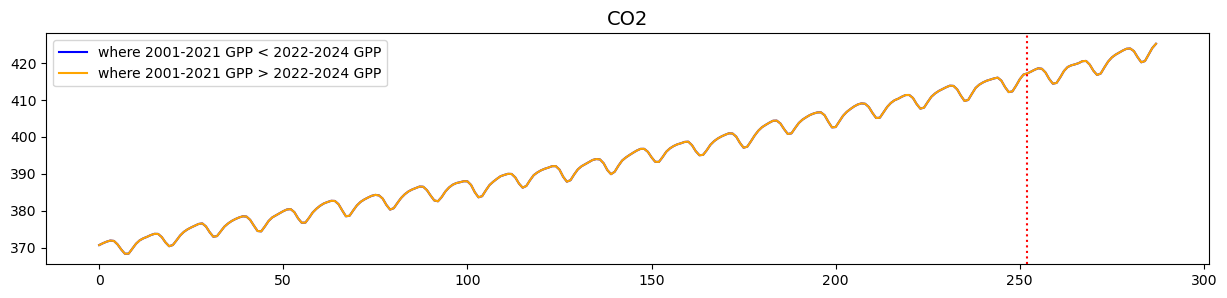

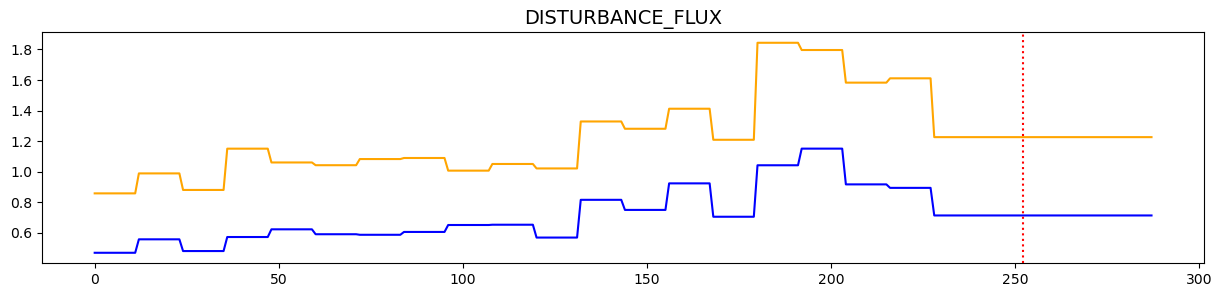

In [233]:
for i in list(x for x in DCInput.data_vars if DCInput[x].shape[0]==288 and 'G' not in x and 'Y' not in x)[1:11]:
    plt.figure(figsize=(15,3))
    plt.plot((DCInput[i]*LandFrac.LandArea).where(~np.isnan(data1.mean('time_fluxes'))).sum(
        'latitude').sum('longitude')/LandFrac.LandArea.where(~np.isnan(data1.mean('time_fluxes'))).sum(
        'latitude').sum('longitude'),color='blue',label='where 2001-2021 GPP < 2022-2024 GPP')
    plt.plot((DCInput[i]*LandFrac.LandArea).where(~np.isnan(data2.mean('time_fluxes'))).sum(
        'latitude').sum('longitude')/LandFrac.LandArea.where(~np.isnan(data2.mean('time_fluxes'))).sum(
        'latitude').sum('longitude'),color='orange',label='where 2001-2021 GPP > 2022-2024 GPP')
    plt.title(i,fontsize=14)
    plt.axvline(x=252,linestyle='dotted',color='red')
    plt.legend()

plt.figure(figsize=(15,3))
plt.plot((DCInput['DISTURBANCE_FLUX']*LandFrac.LandArea).where(~np.isnan(data1.mean('time_fluxes'))).sum(
        'latitude').sum('longitude')/LandFrac.LandArea.where(~np.isnan(data1.mean('time_fluxes'))).sum(
        'latitude').sum('longitude'),color='blue',label='where 2001-2021 GPP < 2022-2024 GPP')
plt.plot((DCInput['DISTURBANCE_FLUX']*LandFrac.LandArea).where(~np.isnan(data2.mean('time_fluxes'))).sum(
        'latitude').sum('longitude')/LandFrac.LandArea.where(~np.isnan(data2.mean('time_fluxes'))).sum(
        'latitude').sum('longitude'),color='orange',label='where 2001-2021 GPP > 2022-2024 GPP')
plt.title('DISTURBANCE_FLUX',fontsize=14)
plt.axvline(x=252,linestyle='dotted',color='red')
    